In [1]:
!pip install sqlalchemy

In [2]:
!pip install yfinance

In [3]:
import yfinance as yf
from pprint import pprint
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt

# Get Data from Yahoo Finance #

In [4]:
securities = ['SPY', 'MSCI', 'VENAX', 'IYT', 'VGHCX', '^IXIC']

In [5]:
long_names=[]
short_names=[]
for each_ticker in securities: 
    ticker=yf.Ticker(each_ticker)
    info=ticker.info
    try: 
        long_name=info['longName']
    except: 
        long_name=''
        print(f"Couldn't find long name for {each_ticker}")
    try: 
        short_name=info['shortName']
    except: 
        short_name=''
        print(f"Couldn't find short name for {each_ticker}")
    long_names.append(long_name)
    short_names.append(short_name)

Couldn't find long name for ^IXIC


In [6]:
# long_names.append('NASDAQ Composite')
# short_names.append('NASDAQ Composite')
df=pd.DataFrame({'ticker': securities, 
                 'long_names': long_names, 
                 'short_names': short_names, 
                })
df

,ticker,long_names,short_names
0,SPY,SPDR S&P 500 ETF Trust,SPDR S&P 500
1,MSCI,MSCI Inc.,MSCI Inc
2,VENAX,Vanguard Energy Index Fund,Vanguard Energy Index Fund Admi
3,IYT,iShares Transportation Average ETF,iShares Trust iShares U.S. Tran
4,VGHCX,Vanguard Health Care Fund,Vanguard Specialized Portfolios
5,^IXIC,,NASDAQ Composite


# Store Data in SQLite DB #

In [32]:
engine=sql.create_engine('sqlite:///recession_analysis.db')

In [27]:
# column_names_ticker=['ticker', 'long_names', 'short_names']
df.to_sql('tickers', con=engine, index=False)

### Query DB To Check ###

In [29]:
sql_query='select * from tickers'
results=engine.execute(sql_query).all()
results

[('SPY', 'SPDR S&P 500 ETF Trust', 'SPDR S&P 500'),
 ('MSCI', 'MSCI Inc.', 'MSCI Inc'),
 ('VENAX', 'Vanguard Energy Index Fund', 'Vanguard Energy Index Fund Admi'),
 ('IYT', 'iShares Transportation Average ETF', 'iShares Trust iShares U.S. Tran'),
 ('VGHCX', 'Vanguard Health Care Fund', 'Vanguard Specialized Portfolios'),
 ('^IXIC', 'NASDAQ Composite', 'NASDAQ Composite')]

# Get Price History #

In [49]:
# column_names_price_history=['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'ticker']

engine.execute('drop table if exists price_history')

for each_ticker in securities: 
    ticker=yf.Ticker(each_ticker)
    hist=ticker.history(period="max")
    hist=hist.reset_index()
    hist['ticker']=each_ticker
    hist.to_sql('price_history', con=engine, index=False, if_exists='append')

### Query DB To Check ###

In [126]:
ticker='MSCI'
sql_query=f'select * from price_history where ticker="{ticker}"'
price_history_by_ticker=pd.read_sql(sql_query, con=engine, index_col='Date', parse_dates='Date')
price_history_by_ticker.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2007-11-15,21.111212,26.113652,20.248405,23.956636,11770500,0.0,0,MSCI
2007-11-16,23.846494,23.846494,21.661943,22.910257,1242900,0.0,0,MSCI
2007-11-19,22.680785,23.635380,22.515568,23.635380,469500,0.0,0,MSCI
2007-11-20,23.332479,26.811239,23.185619,25.076448,522200,0.0,0,MSCI
2007-11-21,24.782730,24.902053,23.809778,24.461472,167500,0.0,0,MSCI


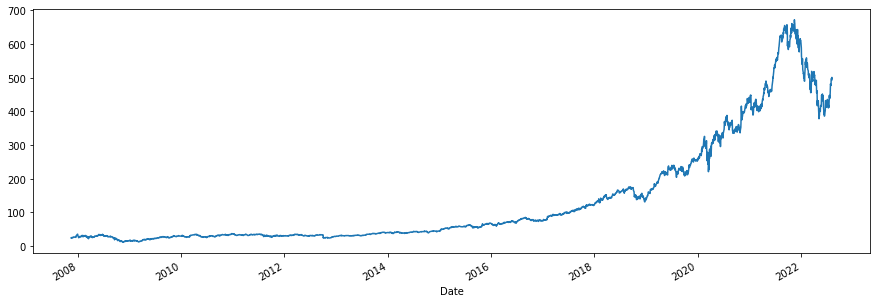

In [227]:
fig, ax=plt.subplots(figsize=(15, 5))
price_history_by_ticker['Close'].plot(ax=ax)
fig.savefig('./images/trend.png')

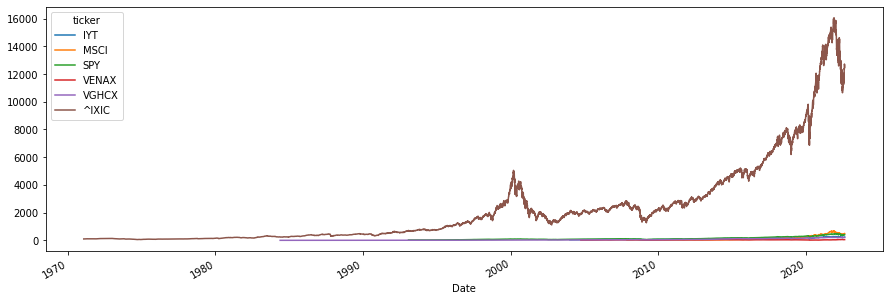

In [267]:
sql_query=f'select * from price_history'
price_history=pd.read_sql(sql_query, con=engine, index_col='Date', parse_dates='Date')

fig, ax=plt.subplots(figsize=(15, 5))

price_history=price_history.pivot(columns='ticker', values='Close')
price_history.plot(ax=ax)

fig.savefig('./images/all_tickers_trend.png')

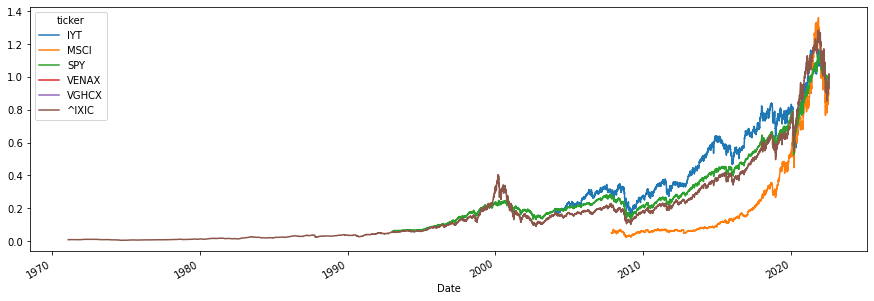

In [268]:
sql_query=f'select * from price_history'
price_history=pd.read_sql(sql_query, con=engine, index_col='Date', parse_dates='Date')

fig, ax=plt.subplots(figsize=(15, 5))

price_history=price_history.pivot(columns='ticker', values='Close')
(price_history/price_history.iloc[-1]).plot(ax=ax)

fig.savefig('./images/all_tickers_normalized_trend.png')

# Set Recession Period #

In [269]:
recessions={
    'savings_and_loans_crisis': pd.date_range('1990-07', '1991-03'), 
    'dot_com_bust': pd.date_range('2001-03', '2001-11'), 
    'great_recession': pd.date_range('2007-12', '2009-06'), 
    'covid': pd.date_range('2020-04', '2020-06'), 
    # subject to change
    'current': pd.date_range('2022-01', '2022-08-09')
}

In [252]:
for recession_name, recession_dates in recessions.items(): 
    price_history_by_ticker.loc[price_history_by_ticker.index.isin(recession_dates), 'event']=recession_name

price_history_by_ticker['event']=price_history_by_ticker['event'].fillna('normal')
price_history_by_ticker['event'].value_counts()

normal             3139
great_recession     376
current             151
covid                42
Name: event, dtype: int64

In [253]:
price_by_event=price_history_by_ticker.pivot(columns='event', values='Close')

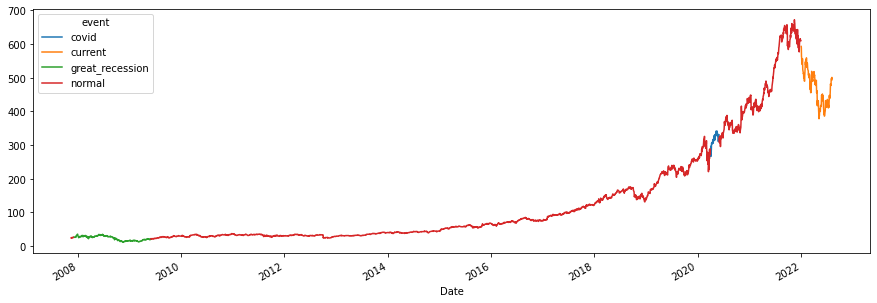

In [254]:
fig, ax=plt.subplots(figsize=(15, 5))
price_by_event.plot(ax=ax)
fig.savefig('./images/trend_by_event.png')

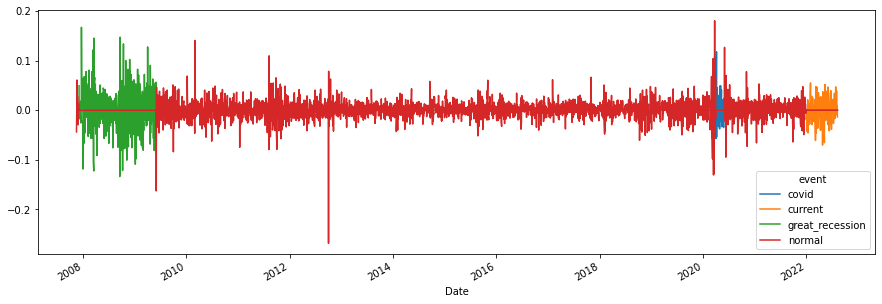

In [255]:
fig, ax=plt.subplots(figsize=(15, 5))
price_by_event.pct_change().plot(ax=ax)
fig.savefig('./images/daily_return_trend_by_event.png')

# Calculate Variance #

In [256]:
sql_query=f'select * from price_history'
price_history=pd.read_sql(sql_query, con=engine, index_col='Date', parse_dates='Date')

price_history=price_history.pivot(columns='ticker', values='Close').pct_change()
price_history.head()

ticker,IYT,MSCI,SPY,VENAX,VGHCX,^IXIC
Date,,,,,,
1971-02-05,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-08,NaN,NaN,NaN,NaN,NaN,0.008400
1971-02-09,NaN,NaN,NaN,NaN,NaN,-0.000793
1971-02-10,NaN,NaN,NaN,NaN,NaN,-0.000695
1971-02-11,NaN,NaN,NaN,NaN,NaN,0.007548


In [260]:
var_df=pd.DataFrame(price_history.var(axis=1), columns=['variance'])

for recession_name, recession_dates in recessions.items(): 
    var_df.loc[var_df.index.isin(recession_dates), 'event']=recession_name

var_df['event']=var_df['event'].fillna('normal')
var_df

,variance,event
Date,,
1971-02-05,NaN,normal
1971-02-08,NaN,normal
1971-02-09,NaN,normal
1971-02-10,NaN,normal
1971-02-11,NaN,normal
...,...,...
2022-08-03,0.000494,current
2022-08-04,0.000277,current
2022-08-05,0.000088,current


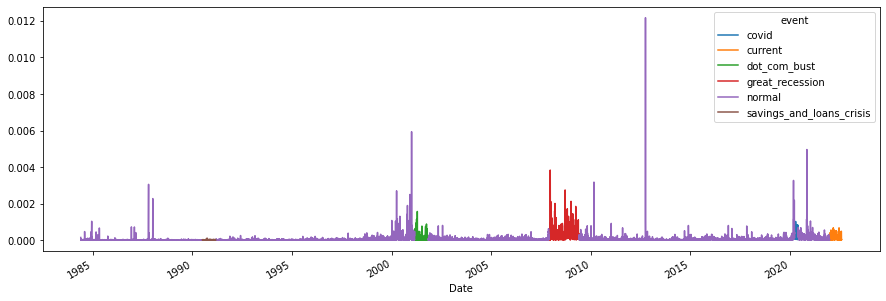

In [261]:
fig, ax=plt.subplots(figsize=(15, 5))
var_df.pivot(columns='event', values='variance').plot(ax=ax)
fig.savefig('./images/variance_over_time.png')

# Calculate Correlation #

### Calculate Mean Correlation ###

In [262]:
sql_query=f'select * from price_history'
price_history=pd.read_sql(sql_query, con=engine, index_col='Date', parse_dates='Date')

price_history=price_history.pivot(columns='ticker', values='Close').pct_change()
price_history.head()

ticker,IYT,MSCI,SPY,VENAX,VGHCX,^IXIC
Date,,,,,,
1971-02-05,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-08,NaN,NaN,NaN,NaN,NaN,0.008400
1971-02-09,NaN,NaN,NaN,NaN,NaN,-0.000793
1971-02-10,NaN,NaN,NaN,NaN,NaN,-0.000695
1971-02-11,NaN,NaN,NaN,NaN,NaN,0.007548


In [263]:
corr_matrix={}
for recession_name, recession_dates in recessions.items(): 
    corr_df=price_history.loc[price_history.index.isin(recession_dates)]
    corr_matrix[recession_name]=corr_df.corr().mean().mean()

corr_matrix

{'savings_and_loans_crisis': 0.961913739924791,
 'dot_com_bust': 0.7825227698932656,
 'great_recession': 0.7717761091710883,
 'covid': 0.7724242197927399,
 'current': 0.6878973647829506}

### Calculate Rolling Correlation ###

In [264]:
sql_query=f'select * from price_history'
price_history=pd.read_sql(sql_query, con=engine, index_col='Date', parse_dates='Date')

price_history=price_history.pivot(columns='ticker', values='Close').pct_change()
price_history.head()

ticker,IYT,MSCI,SPY,VENAX,VGHCX,^IXIC
Date,,,,,,
1971-02-05,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-08,NaN,NaN,NaN,NaN,NaN,0.008400
1971-02-09,NaN,NaN,NaN,NaN,NaN,-0.000793
1971-02-10,NaN,NaN,NaN,NaN,NaN,-0.000695
1971-02-11,NaN,NaN,NaN,NaN,NaN,0.007548


In [265]:
corr_df=price_history.rolling(30).corr()
corr_df=corr_df.mean(level=0).mean(axis=1)
corr_df

Date
1971-02-05         NaN
1971-02-08         NaN
1971-02-09         NaN
1971-02-10         NaN
1971-02-11         NaN
                ...   
2022-08-03    0.645071
2022-08-04    0.648135
2022-08-05    0.664724
2022-08-08    0.641099
2022-08-09    0.649656
Length: 12991, dtype: float64

<AxesSubplot:xlabel='Date'>

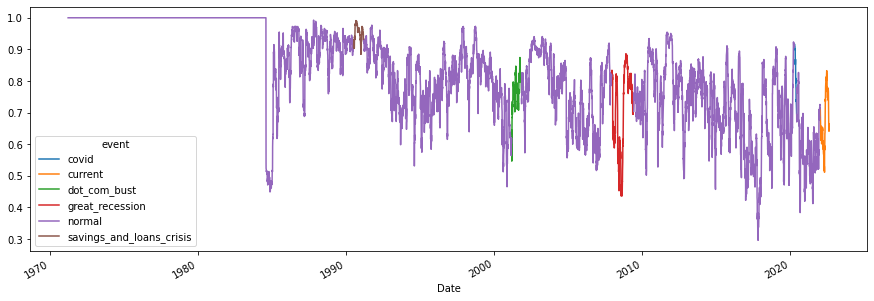

In [266]:
corr_df=pd.DataFrame(corr_df, columns=['rolling_corr'])

for recession_name, recession_dates in recessions.items(): 
    corr_df.loc[price_history.index.isin(recession_dates), 'event']=recession_name

corr_df['event']=corr_df['event'].fillna('normal')
corr_df.pivot(columns='event', values='rolling_corr').plot(figsize=[15, 5])